In [1]:
import tensorflow as tf

In [2]:
print("Tensorflow version: {}".format(tf.__version__))

Tensorflow version: 2.10.0


In [3]:
from tensorflow import keras

In [4]:
from keras import layers

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pathlib

In [6]:
data_dir = "./dataset/moc"

In [7]:
data_root = pathlib.Path(data_dir)

In [8]:
data_root

WindowsPath('dataset/moc')

In [9]:
for item in data_root.iterdir():
    print(item)

dataset\moc\black_jeans
dataset\moc\black_shoes
dataset\moc\blue_dress
dataset\moc\blue_jeans
dataset\moc\blue_shirt
dataset\moc\red_dress
dataset\moc\red_shirt


In [10]:
all_image_paths = list(data_root.glob("*/*"))

In [11]:
image_count = len(all_image_paths)
image_count

2525

In [12]:
import random
all_image_paths = [str(path) for path in all_image_paths]
random.shuffle(all_image_paths)

In [13]:
all_image_paths[:5]

['dataset\\moc\\red_dress\\00000291.jpg',
 'dataset\\moc\\black_shoes\\00000188.jpg',
 'dataset\\moc\\red_dress\\00000338.jpg',
 'dataset\\moc\\blue_jeans\\00000200.jpg',
 'dataset\\moc\\red_shirt\\00000146.jpg']

In [14]:
# sorted 方法返回一个新的list
label_names = sorted(item.name for item in data_root.glob("*/") if item.is_dir())
label_names

['black_jeans',
 'black_shoes',
 'blue_dress',
 'blue_jeans',
 'blue_shirt',
 'red_dress',
 'red_shirt']

In [15]:
label_names[:5]

['black_jeans', 'black_shoes', 'blue_dress', 'blue_jeans', 'blue_shirt']

In [16]:
color_image_label = set(item_name.split("_")[0] for item_name in label_names)

In [17]:
color_image_label

{'black', 'blue', 'red'}

In [18]:
type_image_label = set(item_name.split("_")[1] for item_name in label_names)

In [19]:
type_image_label

{'dress', 'jeans', 'shirt', 'shoes'}

In [20]:
color_image_label_dict = dict((name, index) for index,name in enumerate(color_image_label))

In [21]:
type_image_label_dict = dict((name, index) for index, name in enumerate(type_image_label))

In [22]:
type_image_label_dict

{'shoes': 0, 'jeans': 1, 'dress': 2, 'shirt': 3}

In [23]:
# 测试取出所有的标签
# path = all_image_paths[0]
# path
# pathlib.Path(path).parent.name
# 'red_shirt'

In [24]:
all_image_labels = [pathlib.Path(path).parent.name for path in all_image_paths]
all_image_labels[:5]

['red_dress', 'black_shoes', 'red_dress', 'blue_jeans', 'red_shirt']

In [25]:
color_labels = [color_image_label_dict[item_name.split("_")[0]] for item_name in all_image_labels]

In [26]:
color_labels[:5]

[2, 1, 2, 0, 2]

In [27]:
type_labels = [type_image_label_dict[item_name.split("_")[1]] for item_name in all_image_labels]

In [28]:
type_labels[:5]

[2, 0, 2, 1, 3]

In [29]:
import IPython.display as display

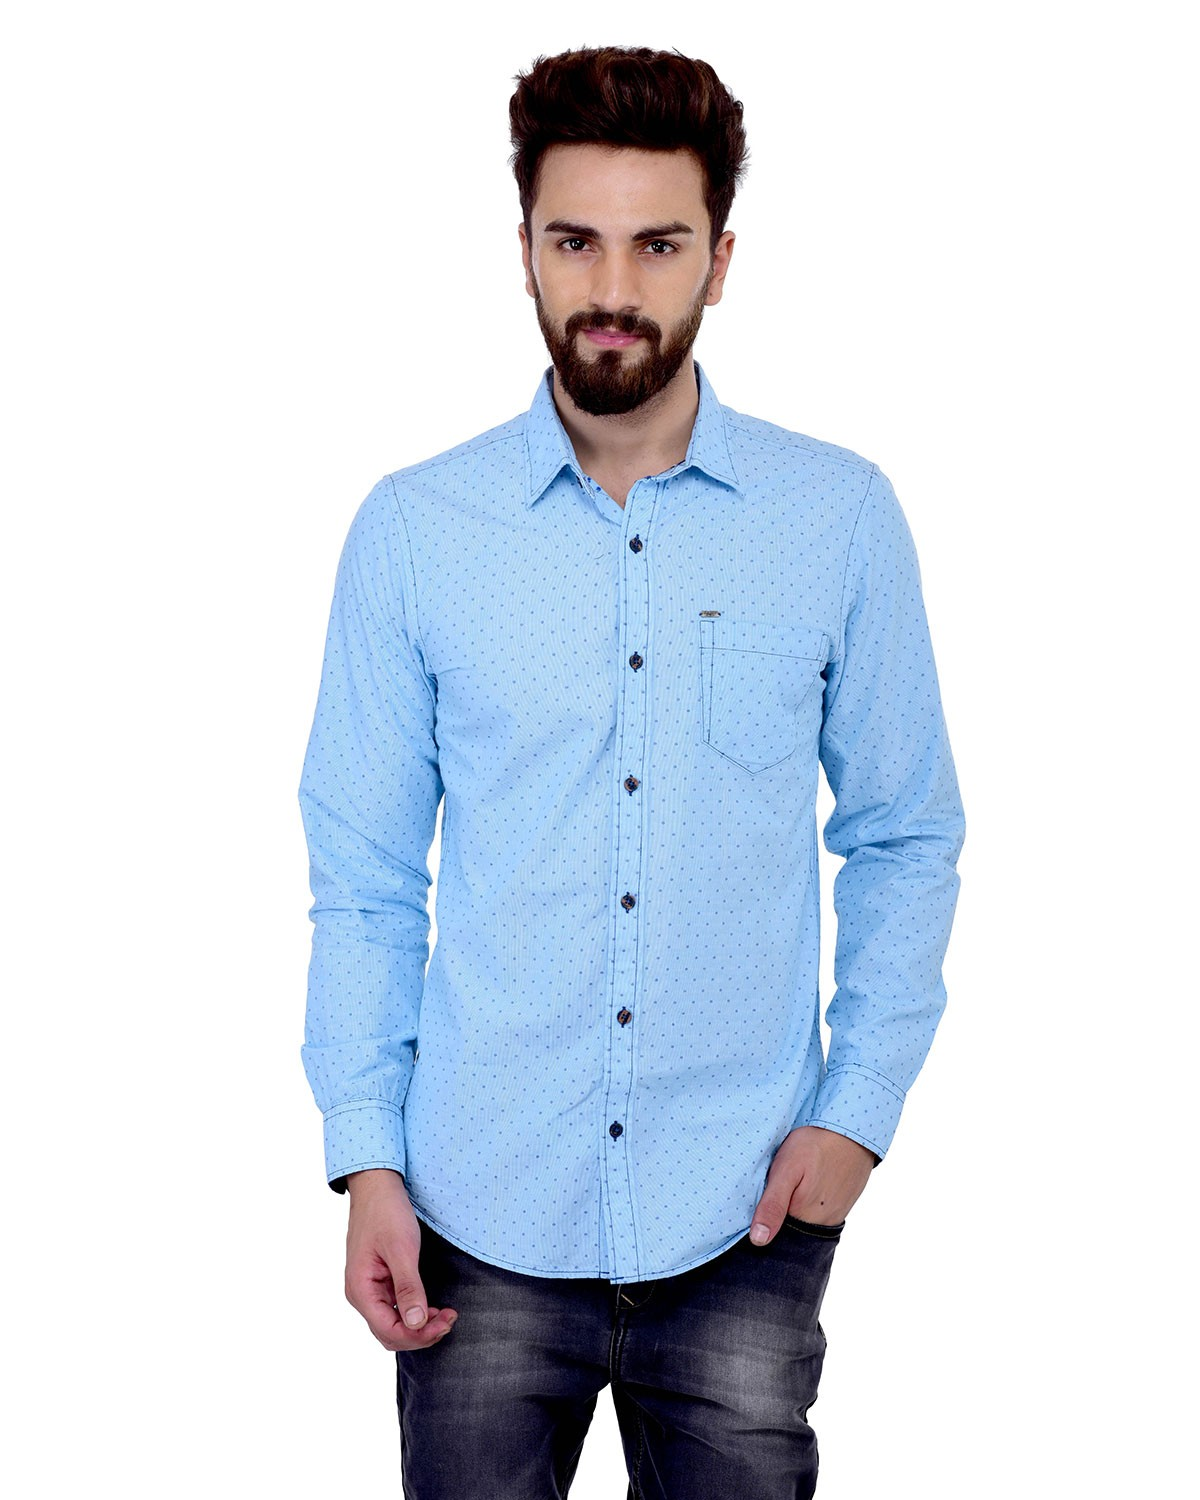

blue_shirt



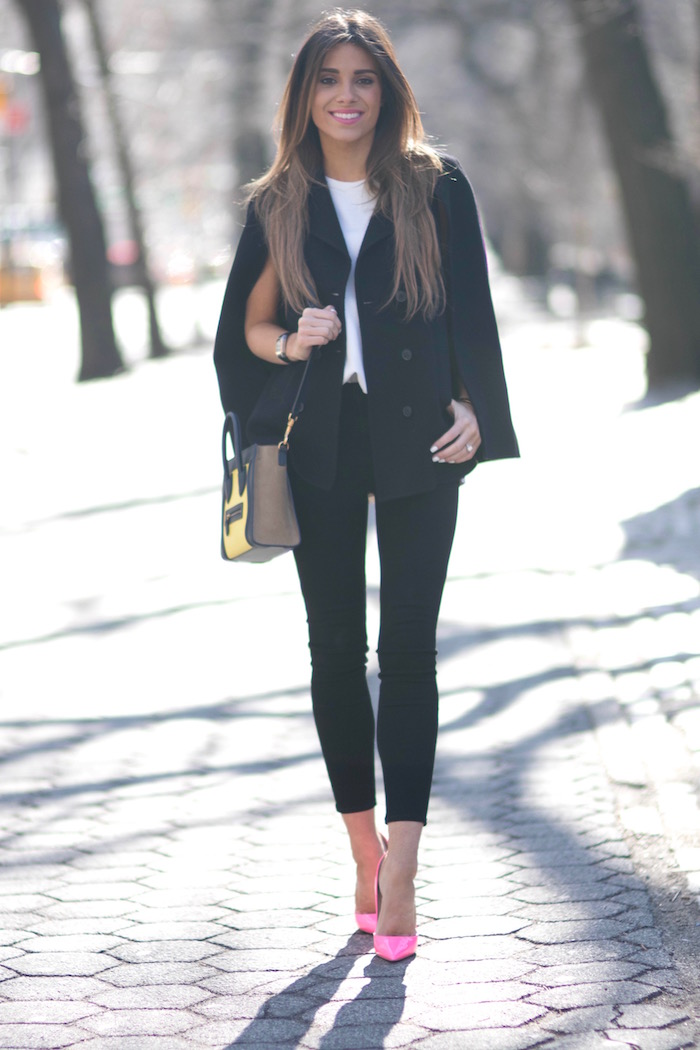

black_jeans



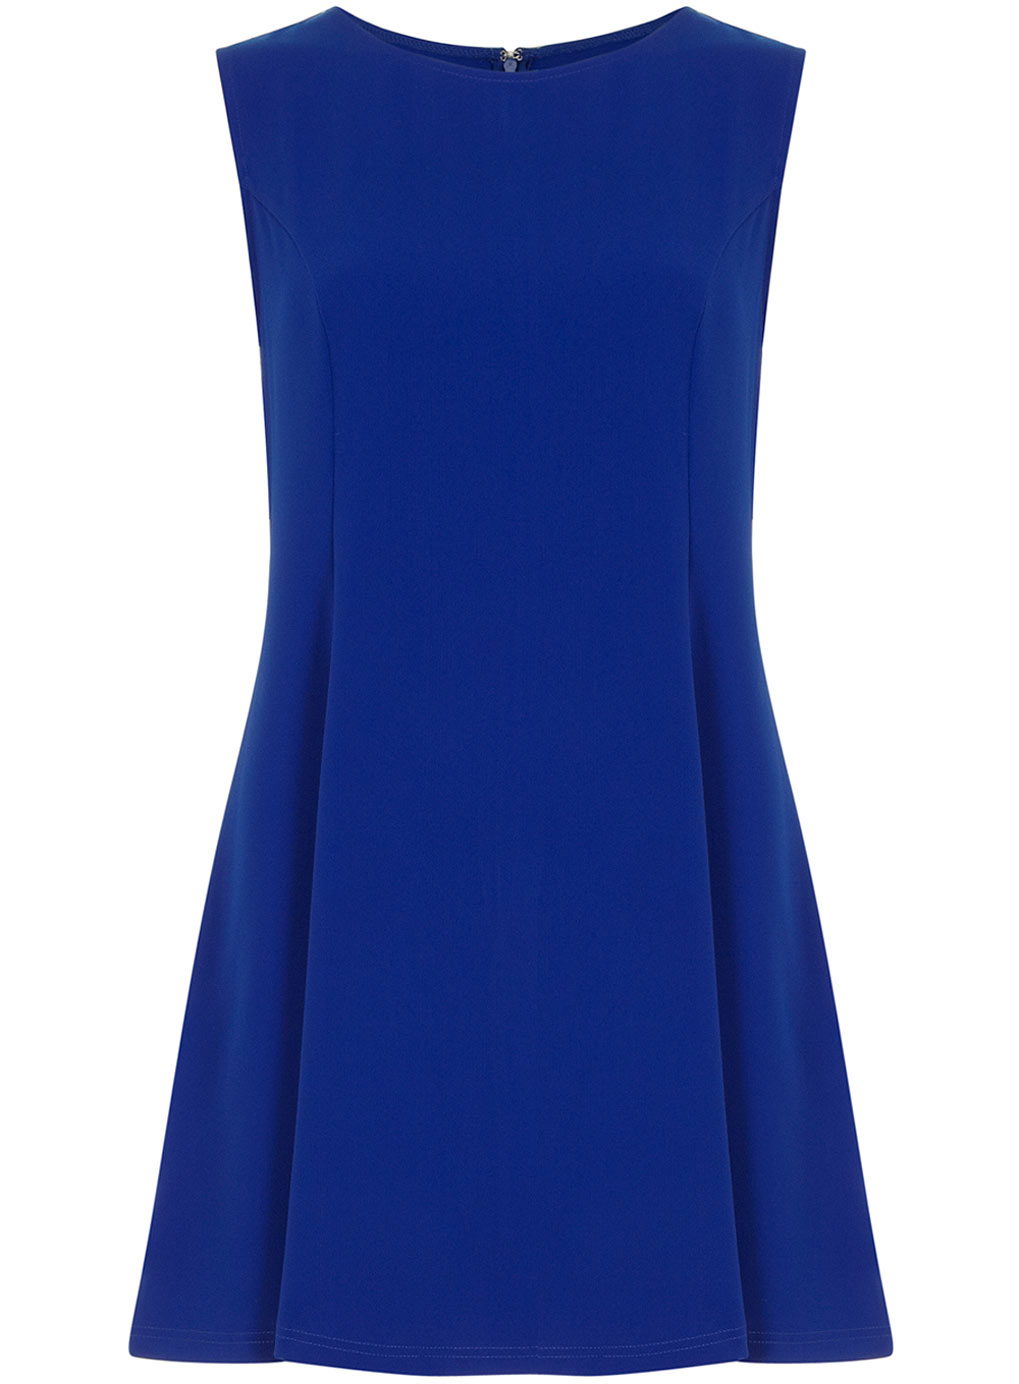

blue_dress



In [30]:
for n in range(3):
    image_index = random.choice(range(len(all_image_paths)))
    display.display(display.Image(all_image_paths[image_index], width=100,height=100))
    print(all_image_labels[image_index])
    print()

### 加载和格式化图片

In [31]:
image_path = all_image_paths[0]
image_path

'dataset\\moc\\red_dress\\00000291.jpg'

In [32]:
image_raw = tf.io.read_file(image_path)
print(repr(image_raw)[:100]+"...")

<tf.Tensor: shape=(), dtype=string, numpy=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00...


In [33]:
image_tensor = tf.image.decode_image(image_raw)
print(image_tensor.shape)
print(image_tensor.dtype)

(1225, 736, 3)
<dtype: 'uint8'>


### 加载和处理图片函数

In [34]:
def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224,224])
    image = tf.cast(image, tf.float32)
    image = image/255.0
    image = 2*image-1
    return image

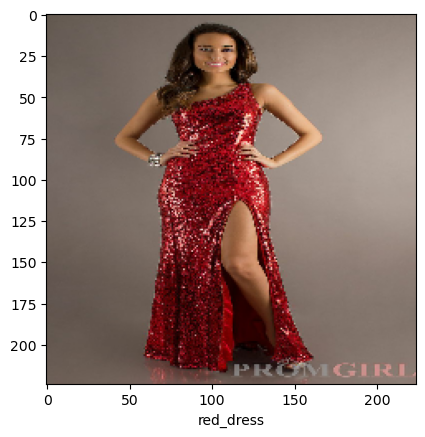

In [35]:
image_path = all_image_paths[0]
label = all_image_labels[0]
plt.imshow((load_and_preprocess_image(image_path) + 1)/2)
plt.grid(False)
plt.xlabel(label)
print()

In [36]:
path_dataset = tf.data.Dataset.from_tensor_slices(all_image_paths)

In [37]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
image_dataset = path_dataset.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)

In [38]:
# 需要理解from_tensor_slices
label_dataset = tf.data.Dataset.from_tensor_slices((color_labels, type_labels))

In [39]:
for ele in label_dataset.take(3):
    print(ele[0].numpy(), ele[0].numpy())

2 2
1 1
2 2


In [40]:
image_label_dataset = tf.data.Dataset.zip((image_dataset, label_dataset))

In [41]:
image_label_dataset

<ZipDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), (TensorSpec(shape=(), dtype=tf.int32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None)))>

In [42]:
test_count = int(image_count * 0.2)
train_count = image_count - test_count

In [43]:
train_data = image_label_dataset.skip(test_count)
test_data = image_label_dataset.take(test_count)

In [44]:
BATCH_SIZE = 16

In [45]:
train_data = train_data.shuffle(buffer_size=train_count).repeat(-1)
train_data = train_data.batch(BATCH_SIZE)
train_data = train_data.prefetch(buffer_size=AUTOTUNE)
train_data

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), (TensorSpec(shape=(None,), dtype=tf.int32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None)))>

In [46]:
test_data = test_data.batch(BATCH_SIZE)

### 建立模型

In [47]:
moblie_net = tf.keras.applications.MobileNetV2(
    input_shape=(224,224,3),
    include_top=False,
    weights="imagenet"
)

In [48]:
moblie_net.trainable = False

In [49]:
inputs = tf.keras.Input(shape=(224,224,3))

In [50]:
x = moblie_net(inputs)

In [51]:
x.get_shape()

TensorShape([None, 7, 7, 1280])

In [52]:
x = tf.keras.layers.GlobalAveragePooling2D()(x)

In [53]:
x.get_shape()

TensorShape([None, 1280])

In [54]:
x1 = tf.keras.layers.Dense(1024, activation="relu")(x)
out_color = tf.keras.layers.Dense(
    len(color_image_label),
    activation="softmax",
    name='out_color'
)(x1)

In [55]:
x2 = tf.keras.layers.Dense(1024, activation="relu")(x)
out_type = tf.keras.layers.Dense(
    len(type_image_label),
    activation="softmax",
    name='out_type'
)(x2)

In [56]:
model = tf.keras.Model(
    inputs=inputs,
    outputs=[out_color, out_type]
)

In [57]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 mobilenetv2_1.00_224 (Function  (None, 7, 7, 1280)  2257984     ['input_2[0][0]']                
 al)                                                                                              
                                                                                                  
 global_average_pooling2d (Glob  (None, 1280)        0           ['mobilenetv2_1.00_224[0][0]']   
 alAveragePooling2D)                                                                          

In [58]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss={
        "out_color":"sparse_categorical_crossentropy",
        "out_type":"sparse_categorical_crossentropy"
    },
    metrics=["acc"]
)

In [59]:
train_steps = train_count//BATCH_SIZE
test_steps = test_count//BATCH_SIZE

In [60]:
model.fit(
    train_data,
    steps_per_epoch=train_steps,
    epochs=15,
    validation_data=test_data,
    validation_steps=test_steps
)

Epoch 1/15
126/126 [==============================] - 82s 509ms/step - loss: 0.4208 - out_color_loss: 0.2920 - out_type_loss: 0.1289 - out_color_acc: 0.9028 - out_type_acc: 0.9643 - val_loss: 0.2340 - val_out_color_loss: 0.2003 - val_out_type_loss: 0.0337 - val_out_color_acc: 0.9496 - val_out_type_acc: 0.9940
Epoch 2/15
126/126 [==============================] - 65s 517ms/step - loss: 0.1021 - out_color_loss: 0.0896 - out_type_loss: 0.0126 - out_color_acc: 0.9816 - out_type_acc: 0.9985 - val_loss: 0.1661 - val_out_color_loss: 0.1416 - val_out_type_loss: 0.0246 - val_out_color_acc: 0.9577 - val_out_type_acc: 0.9919
Epoch 3/15
126/126 [==============================] - 63s 502ms/step - loss: 0.0555 - out_color_loss: 0.0502 - out_type_loss: 0.0053 - out_color_acc: 0.9901 - out_type_acc: 0.9995 - val_loss: 0.1342 - val_out_color_loss: 0.1181 - val_out_type_loss: 0.0161 - val_out_color_acc: 0.9657 - val_out_type_acc: 0.9960
Epoch 4/15
126/126 [==============================] - 63s 502ms/ste

In [61]:
model.evaluate(test_data)

32/32 [==============================] - 13s 405ms/step - loss: 0.1268 - out_color_loss: 0.1145 - out_type_loss: 0.0124 - out_color_acc: 0.9703 - out_type_acc: 0.9980


[0.12684206664562225,
 0.11446050554513931,
 0.01238157507032156,
 0.9702970385551453,
 0.998019814491272]

In [92]:
my_image = load_and_preprocess_image(r'dataset\\custom_images\\1.jpg')

In [93]:
my_image = tf.expand_dims(my_image, 0)

In [94]:
pred = model.predict(my_image)

1/1 [==============================] - 0s 54ms/step


In [95]:
np.argmax(pred[0])

0

In [96]:
np.argmax(pred[1])

2

In [97]:
index_type_label_dict = dict((name, index) for name, index in enumerate(type_image_label_dict))
index_type_label_dict

{0: 'shoes', 1: 'jeans', 2: 'dress', 3: 'shirt'}

In [98]:
index_color_label_dict = dict((name, index) for name, index in enumerate(color_image_label_dict))
index_color_label_dict

{0: 'blue', 1: 'black', 2: 'red'}

In [99]:
color_name = index_color_label_dict[np.argmax(pred[0])]
type_name = index_type_label_dict[np.argmax(pred[1])]
pred_name = color_name + "_" + type_name
pred_name

'blue_dress'

Text(0.5, 0, 'blue_dress')

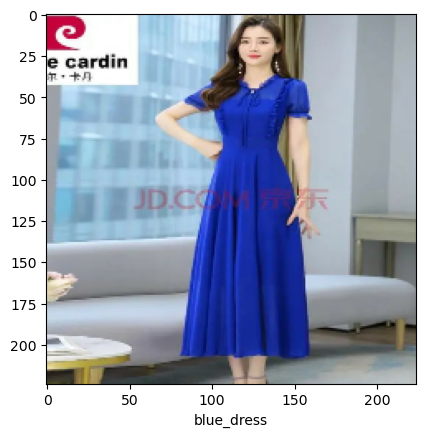

In [101]:
plt.imshow((load_and_preprocess_image(r'dataset\\custom_images\\1.jpg') + 1)/2)
plt.grid(False)
plt.xlabel(pred_name)